# Object: 验证lambda layer和loss的等价性
## 构造一个简单的数据集，然后使用lambda和loss分别fit，看weight是否等价

### KR1: 把loss作为layer还是loss function看不出差异点
### KR2: 经常train坏掉，为什么？overfit?
### KR3: sigmoid和tanh为什么不工作？和relu的差异很大

KR2 问题：  ~~注意到一些layer没有被initialized到，所以导致无法被train到，所以导致了~~ 不对，一些dense的bias确实是init成0的。和overfit没关系

KR1: loss作为layer和loss fn结果非常类似, 在activation=tanh的情况下表现明显，tanh和relu不同的是tanh很稳定

KR3: tanh & sigmoid的activation，被缩在一起，基本上是一个直线，underfit很严重

In [48]:
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.models import Model, Sequential, Input
import matplotlib.pyplot as plt
import keras
from keras.models import Model, Sequential, Input
from keras.layers import Dense, Lambda, Dropout
from keras import losses
%matplotlib inline

In [49]:
## generate the X
def sample(size):
    X = np.random.random(size) * 2.0 - 1.0
    noise = np.random.random(size) / 10.0
    Y = X * X + 1.0 + noise
    return X.reshape(size, 1),Y.reshape(size, 1)

train X shape (128, 1)
train y shape (128, 1)


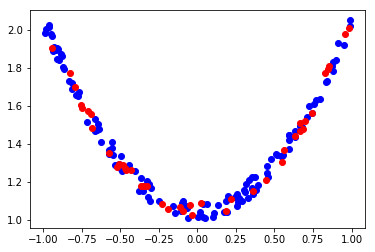

In [50]:
m=64 * 2
train_X, train_y = sample(m)
val_X, val_y = sample(m/3)
layers = [2]
activation = "relu"

# plot the sample and val data
plt.plot(train_X, train_y, "bo")
plt.plot(val_X, val_y, "ro")
print "train X shape", train_X.shape
print "train y shape", train_y.shape

In [51]:
# fit by loss
x_input = Input(shape=(1,))
x = x_input
for num in layers:
    x = Dense(num, activation=activation)(x)
#     x = Dropout(0.2)(x)
x = Dense(1, activation=activation)(x)
model = Model(x_input, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(optimizer='adadelta',
              loss='mse')
model.fit(train_X,
          train_y,
          epochs=100, 
          batch_size=32,
          shuffle=True,
          validation_data = (val_X, val_y))

Train on 128 samples, validate on 42 samples
Epoch 1/100
128/128 [==============================] - 0s 3ms/step - loss: 0.9634 - val_loss: 0.9698
Epoch 2/100
128/128 [==============================] - 0s 53us/step - loss: 0.9538 - val_loss: 0.9602
Epoch 3/100
128/128 [==============================] - 0s 55us/step - loss: 0.9441 - val_loss: 0.9505
Epoch 4/100
128/128 [==============================] - 0s 64us/step - loss: 0.9345 - val_loss: 0.9408
Epoch 5/100
128/128 [==============================] - 0s 50us/step - loss: 0.9248 - val_loss: 0.9311
Epoch 6/100
128/128 [==============================] - 0s 64us/step - loss: 0.9151 - val_loss: 0.9214
Epoch 7/100
128/128 [==============================] - 0s 62us/step - loss: 0.9054 - val_loss: 0.9117
Epoch 8/100
128/128 [==============================] - 0s 79us/step - loss: 0.8956 - val_loss: 0.9020
Epoch 9/100
128/128 [==============================] - 0s 68us/step - loss: 0.8860 - val_loss: 0.8923
Epoch 10/100
128/128 [================

128/128 [==============================] - 0s 57us/step - loss: 0.3138 - val_loss: 0.3150
Epoch 80/100
128/128 [==============================] - 0s 67us/step - loss: 0.3078 - val_loss: 0.3089
Epoch 81/100
128/128 [==============================] - 0s 51us/step - loss: 0.3019 - val_loss: 0.3029
Epoch 82/100
128/128 [==============================] - 0s 78us/step - loss: 0.2960 - val_loss: 0.2970
Epoch 83/100
128/128 [==============================] - 0s 56us/step - loss: 0.2902 - val_loss: 0.2911
Epoch 84/100
128/128 [==============================] - 0s 55us/step - loss: 0.2845 - val_loss: 0.2854
Epoch 85/100
128/128 [==============================] - 0s 54us/step - loss: 0.2789 - val_loss: 0.2797
Epoch 86/100
128/128 [==============================] - 0s 56us/step - loss: 0.2733 - val_loss: 0.2740
Epoch 87/100
128/128 [==============================] - 0s 60us/step - loss: 0.2678 - val_loss: 0.2685
Epoch 88/100
128/128 [==============================] - 0s 55us/step - loss: 0.2624 - 

In [53]:
# fit by a lambda layer
x_input = Input(shape=(1,))
x = x_input
for num in layers:
    x = Dense(num, activation=activation)(x)
    x = Dropout(0.2)(x)
x = Dense(1, activation=activation)(x)

def loss_fn(args):
    (y_,y) = args
    return losses.mean_squared_error(y, y_)

loss_model_predictor = Model(input = x_input, output = x)

y_input = Input(shape=(1,))

loss_layer = Lambda(loss_fn, 
            output_shape=(1, ),
            name='yolo_loss',
            arguments={})([x, y_input])

loss_model = Model(input = ([x_input, y_input]), outputs = loss_layer)

loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 2)            4           input_18[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2)            0           dense_33[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 1)            3           dropout_7[0][0]                  
__________________________________________________________________________________________________
input_19 (

/Library/Python/2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  del sys.path[0]
/Library/Python/2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("yo..., inputs=[<tf.Tenso...)`


In [54]:
# train the loss layer model
loss_model.compile(optimizer='adadelta',
              loss=lambda y, y_: y_)
loss_model.fit([train_X, train_y], np.zeros(len(train_y)),
               epochs=100, 
               batch_size=32,
               shuffle=True, 
               validation_data = ([val_X, val_y], np.zeros(len(val_y))))

Train on 128 samples, validate on 42 samples
Epoch 1/100
128/128 [==============================] - 1s 5ms/step - loss: 1.7217 - val_loss: 1.6425
Epoch 2/100
128/128 [==============================] - 0s 73us/step - loss: 1.7198 - val_loss: 1.6321
Epoch 3/100
128/128 [==============================] - 0s 71us/step - loss: 1.7537 - val_loss: 1.6221
Epoch 4/100
128/128 [==============================] - 0s 61us/step - loss: 1.7417 - val_loss: 1.6119
Epoch 5/100
128/128 [==============================] - 0s 64us/step - loss: 1.7004 - val_loss: 1.6016
Epoch 6/100
128/128 [==============================] - 0s 63us/step - loss: 1.6690 - val_loss: 1.5911
Epoch 7/100
128/128 [==============================] - 0s 72us/step - loss: 1.6860 - val_loss: 1.5810
Epoch 8/100
128/128 [==============================] - 0s 71us/step - loss: 1.6586 - val_loss: 1.5705
Epoch 9/100
128/128 [==============================] - 0s 67us/step - loss: 1.6552 - val_loss: 1.5602
Epoch 10/100
128/128 [================

Epoch 80/100
128/128 [==============================] - 0s 62us/step - loss: 1.0397 - val_loss: 0.9138
Epoch 81/100
128/128 [==============================] - 0s 73us/step - loss: 1.0247 - val_loss: 0.9067
Epoch 82/100
128/128 [==============================] - 0s 67us/step - loss: 1.0290 - val_loss: 0.9000
Epoch 83/100
128/128 [==============================] - 0s 65us/step - loss: 1.0337 - val_loss: 0.8932
Epoch 84/100
128/128 [==============================] - 0s 72us/step - loss: 1.0096 - val_loss: 0.8865
Epoch 85/100
128/128 [==============================] - 0s 59us/step - loss: 1.0813 - val_loss: 0.8797
Epoch 86/100
128/128 [==============================] - 0s 64us/step - loss: 0.9849 - val_loss: 0.8731
Epoch 87/100
128/128 [==============================] - 0s 64us/step - loss: 1.0103 - val_loss: 0.8666
Epoch 88/100
128/128 [==============================] - 0s 65us/step - loss: 1.0599 - val_loss: 0.8600
Epoch 89/100
128/128 [==============================] - 0s 64us/step - lo

evaluate the models


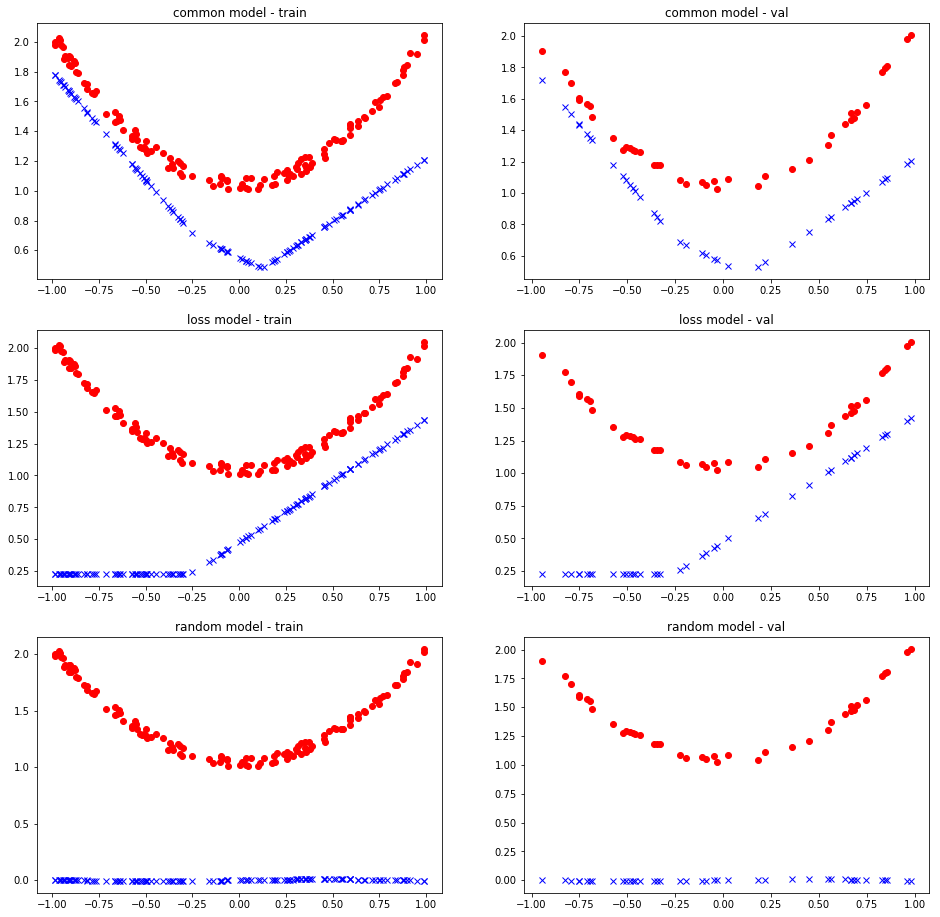

In [55]:
# evaluate the model by plot them
print "evaluate the models"
pred_train_y = model.predict(train_X)
_, axs = plt.subplots(3, 2, figsize = (16, 16))
ax = axs[0][0]
ax.set_title("common model - train")
ax.plot(train_X, train_y, "ro")
ax.plot(train_X, pred_train_y, "bx")

ax = axs[0][1]
ax.set_title("common model - val")
pred_val_y = model.predict(val_X)
ax.plot(val_X, val_y, "ro")
ax.plot(val_X, pred_val_y, "bx")

pred_train_y = loss_model_predictor.predict(train_X)
ax = axs[1][0]
ax.set_title("loss model - train")
ax.plot(train_X, train_y, "ro")
ax.plot(train_X, pred_train_y, "bx")

ax = axs[1][1]
pred_val_y = loss_model_predictor.predict(val_X)
ax.set_title("loss model - val")
ax.plot(val_X, val_y, "ro")
ax.plot(val_X, pred_val_y, "bx")

def random_predictor():
    x_input = Input(shape=(1,))
    x = x_input
    for num in layers:
        x = Dense(num, activation='tanh')(x)
    x = Dense(1, activation='tanh')(x)
    predictor = Model(x_input, x)
    
    return predictor

rand_model_predictor = random_predictor()

pred_train_y = rand_model_predictor.predict(train_X)
ax = axs[2][0]
ax.set_title("random model - train")
ax.plot(train_X, train_y, "ro")
ax.plot(train_X, pred_train_y, "bx")

ax = axs[2][1]
pred_val_y = rand_model_predictor.predict(val_X)
ax.set_title("random model - val")
ax.plot(val_X, val_y, "ro")
ax.plot(val_X, pred_val_y, "bx")

In [56]:
for l in model.layers:
    print l.get_weights()
    print ""

print "debug the loss model:"
for l in loss_model.layers:
    print l.get_weights()
    print ""
    

[]

[array([[ 0.78361011, -1.50344312]], dtype=float32), array([ 0.1887102 ,  0.18681964], dtype=float32)]

[array([[ 1.07707429],
       [ 0.96335989]], dtype=float32), array([ 0.16923204], dtype=float32)]

debug the loss model:
[]

[array([[ 0.60509872,  1.10299277]], dtype=float32), array([ 0.16792974,  0.23887545], dtype=float32)]

[]

[array([[ 1.09422052],
       [ 0.27642435]], dtype=float32), array([ 0.22608031], dtype=float32)]

[]

[]



In [57]:
print model.predict(np.array([-1., -.5, 0., 0.5, 1.]))

[[ 1.79756343]
 [ 1.073385  ]
 [ 0.5524615 ]
 [ 0.7944901 ]
 [ 1.21649325]]


In [81]:
l1, b1 = model.layers[1].get_weights()
l2, b2 = model.layers[2].get_weights()
print "layer 1 weights", l1, b1
print "layer 2 weights", l2, b2
print "" 

x = np.array([[-1.], [-.5], [0.], [0.5], [1.]])
x_ = x * l1 + b1
print "after first layer", x_

x_ = x_ * (x_ > 0)
print "after relu layer", x_

print ""
x_ = x_ * l2 + b2
print "after second layer", x_
x_ = x_ * (x_ > 0)
print "after relu layer", x_

layer 1 weights [[ 0.78361011 -1.50344312]] [ 0.1887102   0.18681964]
layer 2 weights [[ 1.07707429]
 [ 0.96335989]] [ 0.16923204]

after first layer [[-0.59489991  1.69026276]
 [-0.20309485  0.9385412 ]
 [ 0.1887102   0.18681964]
 [ 0.58051525 -0.56490192]
 [ 0.9723203  -1.31662348]]
after relu layer [[-0.          1.69026276]
 [-0.          0.9385412 ]
 [ 0.1887102   0.18681964]
 [ 0.58051525 -0.        ]
 [ 0.9723203  -0.        ]]



ValueError: operands could not be broadcast together with shapes (2,1) (5,2) 